## **Prepare Environment**

In [1]:
import pandas as pd
import hopsworks

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

## **Connect to Hopsworks**

In [2]:
project = hopsworks.login() 
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206998
Connected. Call `.close()` to terminate connection gracefully.


## **Data Processing**

In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    

wine_fg = fs.get_feature_group(name="weather", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                  version=1,
                                  description="Read from Weather dataset",
                                  #labels=["quality_level"],
                                  query=query)

In [4]:
data = feature_view.training_data()[0]
train_data = data.sort_values(by='date')

train_data

Finished: Reading data from Hopsworks, using ArrowFlight (1.35s) 


,date,quality_level,pm25,pm10,so2,no2,co,o3,day_weather_condition,night_weather_condition
504,2013-10-28,6,255,277,30,105,2.60,15,7,6
983,2013-10-29,2,39,62,10,46,0.91,27,1,1
1942,2013-10-30,2,71,101,11,72,1.18,14,1,1
3039,2013-10-31,4,135,162,10,96,1.62,2,2,7
1410,2013-11-01,5,181,202,14,100,1.89,0,7,3
...,...,...,...,...,...,...,...,...,...,...
31,2024-01-03,1,16,33,2,32,0.38,38,1,1
1042,2024-01-04,2,45,71,2,44,0.66,28,1,1
1446,2024-01-05,1,19,44,1,32,0.42,36,1,1
2248,2024-01-06,1,6,14,2,11,0.23,47,1,1


In [5]:
y = train_data['quality_level']
x = train_data[['pm25', 'pm10', 'so2', 'no2', 'co', 'o3', 'day_weather_condition', 'night_weather_condition']]

## **Training Model**

MAE: 0.04
   pm10_real  pm10_pred
0          5          5
1          6          5
2          2          2
3          2          2
4          4          3
5          4          3


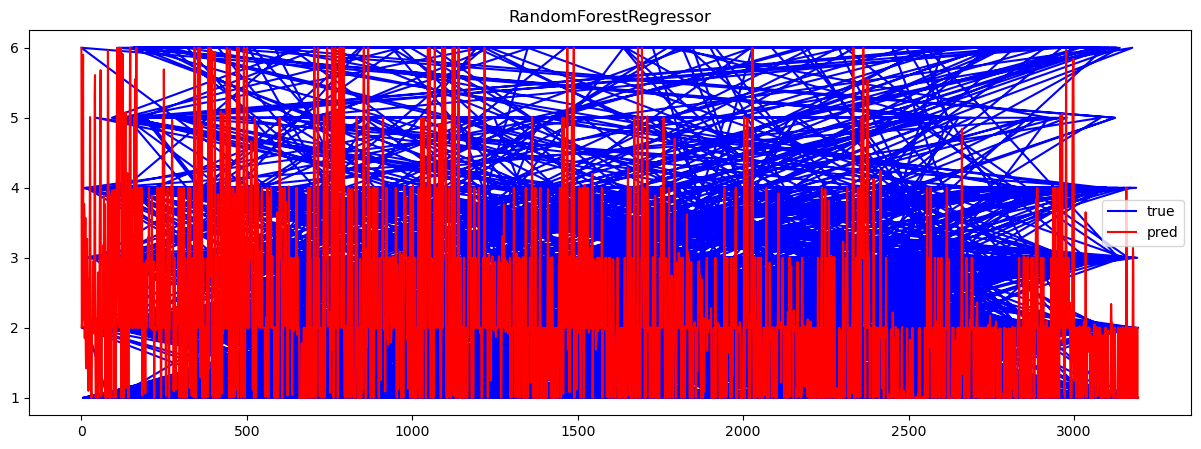

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

model_name = "RandomForestRegressor"
model = RandomForestRegressor()

model.fit(x, y)
mae = mean_absolute_error(y, model.predict(x))
print("MAE: {:.2f}".format(mae))

pred_df = pd.DataFrame({
    'pm10_real': y.iloc[4:10].values,
    'pm10_pred': map(int,model.predict(x.iloc[4:10]))
    })
print(pred_df)
    
fig = plt.figure(figsize=(15,5))
plt.plot(y, label='true', c='b')
plt.plot(model.predict(x), label='pred', c='r')
plt.legend()
plt.title(model_name)
plt.show()  

In [12]:
model_filename = "D:\KTH\ML\BeijingClimateDataAnalysis-master\\random_forest_regressor_model.pkl"

joblib.dump(model, model_filename)

['D:\\KTH\\ML\\BeijingClimateDataAnalysis-master\\random_forest_regressor_model.pkl']

In [13]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from huggingface_hub import Repository
import os

repo_name = "weather"
username = "Antares28"
repo_url = "https://huggingface.co/spaces/Antares28/weather"


repo_path = os.path.join(os.getcwd(), repo_name)
repo = Repository(local_dir=repo_path, clone_from=repo_url)

joblib.dump(model, os.path.join(repo_path, "model.joblib"))

repo.git_add()

repo.git_commit("Add trained random forest model")

repo.git_push()

Cloning https://huggingface.co/spaces/Antares28/weather into local empty directory.


2024-01-15 02:21:20,201 WARNING: Cloning https://huggingface.co/spaces/Antares28/weather into local empty directory.


Upload file model.joblib:   1%|1         | 32.0k/2.22M [00:00<?, ?B/s]

To https://huggingface.co/spaces/Antares28/weather
   13efaba..60a9e31  main -> main



2024-01-15 02:21:28,949 WARNING: To https://huggingface.co/spaces/Antares28/weather
   13efaba..60a9e31  main -> main



'https://huggingface.co/spaces/Antares28/weather/commit/60a9e31787d7cc439a7503853d628c21c7035f69'

In [10]:
mr = project.get_model_registry()

model_dir="RandomForestRegressor"
model_name="rfr_model"

if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

model_file_path = os.path.join(model_dir, model_name + ".pkl")
joblib.dump(model, model_file_path)

input_schema = Schema(x)
output_schema = Schema(y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
    
rfr_model = mr.python.create_model(
        name=model_name,
        metrics={"mae": mae},
        description="RandomForestRegressor with default sklearn parameters",
        input_example=x.sample().to_numpy(),
        model_schema=model_schema
    )

rfr_model.save(model_file_path)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/206998/dataset/upload/Models%2Frfr_model). Server response: 
HTTP code: 500, HTTP reason: Internal Server Error, body: b'{"errorCode":110043,"usrMsg":"Failed to upload./Projects/Irisdataset/Models/rfr_model already exists as a directory\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInternal(FSNamesystem.java:2172)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInt(FSNamesystem.java:2116)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.access$1700(FSNamesystem.java:175)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem$8.performTask(FSNamesystem.java:2076)\\n\\tat io.hops.transaction.handler.TransactionalRequestHandler.execute(TransactionalRequestHandler.java:103)\\n\\tat io.hops.transaction.handler.HopsTransactionalRequestHandler.execute(HopsTransactionalRequestHandler.java:50)\\n\\tat io.hops.transaction.handler.RequestHandler.handle(RequestHandler.java:68)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFile(FSNamesystem.java:2090)\\n\\tat org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.create(NameNodeRpcServer.java:452)\\n\\tat org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.create(ClientNamenodeProtocolServerSideTranslatorPB.java:442)\\n\\tat org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)\\n\\tat org.apache.hadoop.ipc.ProtobufRpcEngine$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine.java:529)\\n\\tat org.apache.hadoop.ipc.RPC$Server.call(RPC.java:1025)\\n\\tat org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:868)\\n\\tat org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:814)\\n\\tat java.security.AccessController.doPrivileged(Native Method)\\n\\tat javax.security.auth.Subject.doAs(Subject.java:422)\\n\\tat org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1821)\\n\\tat org.apache.hadoop.ipc.Server$Handler.run(Server.java:2900)\\n","devMsg":"/Projects/Irisdataset/Models/rfr_model already exists as a directory\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInternal(FSNamesystem.java:2172)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInt(FSNamesystem.java:2116)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.access$1700(FSNamesystem.java:175)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem$8.performTask(FSNamesystem.java:2076)\\n\\tat io.hops.transaction.handler.TransactionalRequestHandler.execute(TransactionalRequestHandler.java:103)\\n\\tat io.hops.transaction.handler.HopsTransactionalRequestHandler.execute(HopsTransactionalRequestHandler.java:50)\\n\\tat io.hops.transaction.handler.RequestHandler.handle(RequestHandler.java:68)\\n\\tat org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFile(FSNamesystem.java:2090)\\n\\tat org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.create(NameNodeRpcServer.java:452)\\n\\tat org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.create(ClientNamenodeProtocolServerSideTranslatorPB.java:442)\\n\\tat org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)\\n\\tat org.apache.hadoop.ipc.ProtobufRpcEngine$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine.java:529)\\n\\tat org.apache.hadoop.ipc.RPC$Server.call(RPC.java:1025)\\n\\tat org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:868)\\n\\tat org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:814)\\n\\tat java.security.AccessController.doPrivileged(Native Method)\\n\\tat javax.security.auth.Subject.doAs(Subject.java:422)\\n\\tat org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1821)\\n\\tat org.apache.hadoop.ipc.Server$Handler.run(Server.java:2900)\\n","errorMsg":"Error occurred while uploading file"}', error code: 110043, error msg: Error occurred while uploading file, user msg: Failed to upload./Projects/Irisdataset/Models/rfr_model already exists as a directory
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInternal(FSNamesystem.java:2172)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFileInt(FSNamesystem.java:2116)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.access$1700(FSNamesystem.java:175)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem$8.performTask(FSNamesystem.java:2076)
	at io.hops.transaction.handler.TransactionalRequestHandler.execute(TransactionalRequestHandler.java:103)
	at io.hops.transaction.handler.HopsTransactionalRequestHandler.execute(HopsTransactionalRequestHandler.java:50)
	at io.hops.transaction.handler.RequestHandler.handle(RequestHandler.java:68)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.startFile(FSNamesystem.java:2090)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.create(NameNodeRpcServer.java:452)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.create(ClientNamenodeProtocolServerSideTranslatorPB.java:442)
	at org.apache.hadoop.hdfs.protocol.proto.ClientNamenodeProtocolProtos$ClientNamenodeProtocol$2.callBlockingMethod(ClientNamenodeProtocolProtos.java)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Server$ProtoBufRpcInvoker.call(ProtobufRpcEngine.java:529)
	at org.apache.hadoop.ipc.RPC$Server.call(RPC.java:1025)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:868)
	at org.apache.hadoop.ipc.Server$RpcCall.run(Server.java:814)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1821)
	at org.apache.hadoop.ipc.Server$Handler.run(Server.java:2900)


In [ ]:

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

model_names = ["Gradient_Duster", "AirParticle_Forest", "PM10Lasso"]

gb = GradientBoostingRegressor()

lasso = Lasso()
models = [gb, rfr, lasso]
models_trained = {m: None for m in model_names}


for i, model in enumerate(models):
    model.fit(x, y)
    mae = mean_absolute_error(y, model.predict(x))
    print("MAE: {:.2f}".format(mae))
    
    pred_df = pd.DataFrame({
    'pm10_real': y.iloc[4:10].values,
    'pm10_pred': map(int, model.predict(x.iloc[4:10]))
    }
    )
    print(pred_df)
    fig = plt.figure(figsize=(15,5))
    plt.plot(y, label='true', c='b')
    plt.plot(model.predict(x), label='pred', c='r')
    plt.legend()
    plt.title(model_names[i])
    plt.show()
    
    models_trained[model_names[i]] = model
    model_name = model_names[i]

    input_schema = Schema(x)
    output_schema = Schema(y)
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
    
    joblib.dump(model, f'{model_name}.temp')
        
    model = mr.sklearn.create_model(
        name=model_name,
        metrics={"mae": mae},
        description=f"{model_name} with default sklearn parameters",
        input_example=x.sample().to_numpy(),
        model_schema=model_schema
    )

    model.save(f'{model_name}.temp')

---